In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
from seabird.cnv import fCNV

In [17]:
# read each seabird cast from your directory
data_dir = 'CNV_post'

cast7 = fCNV(data_dir+'/station7_loop_filter_teos10_bin.cnv')
cast8 = fCNV(data_dir+'/station8_loop_filter_teos10_bin.cnv')
cast9 = fCNV(data_dir+'/slope_loop_filter_teos10_bin.cnv')

#cast added by ewaldo
cast6 = fCNV(data_dir+'/station6_loop_filter_teos10_bin.cnv')
castrace = fCNV(data_dir+'/race_loop_filter_teos10_bin.cnv')

In [319]:
# convert the data one station at a time to xarray
# ideally would make this more generic - but for now, it works!

# Station 9

In [4]:
# get data from cnv file
depth    = cast9['DEPTH']
temperature = cast9['TEMP']
salinity    = cast9['PSAL']
fluorescence = cast9['wetStar']

# put the data in a dictionary
datadic = { 'depth' : depth, 'temperature' : temperature,
            'salinity' : salinity, 'fluorescence' : fluorescence}
#datadic

In [5]:
# convert the dictionary to a pandas dataframe
cast9df=pd.DataFrame.from_dict(datadic)
#cast9df

In [6]:
# convert pandas to xarray
cast9xr = cast9df.set_index('depth').to_xarray()
#cast9xr

In [7]:
# add latitude and longitude coordinates
cast9xr = cast9xr.assign_coords({'latitude': xr.DataArray(cast9.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(cast9.attributes['LONGITUDE']),
                                 'station':9
                                  }
                                  )   
#cast9xr

# Station 8

In [9]:
# get data from cnv file
depth    = cast8['DEPTH']
temperature = cast8['TEMP']
salinity    = cast8['PSAL']
fluorescence = cast8['wetStar']

# put the data in a dictionary
datadic = {'depth' : depth, 'temperature' : temperature,
            'salinity' : salinity, 'fluorescence' : fluorescence}

# convert the dictionary to a pandas dataframe
cast8df=pd.DataFrame.from_dict(datadic)

# convert pandas to xarray
cast8xr = cast8df.set_index('depth').to_xarray()

# add latitude and longitude coordinates
cast8xr = cast8xr.assign_coords({'latitude': xr.DataArray(cast8.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(cast8.attributes['LONGITUDE']),
                                 'station':8
                                  }
                                  )   
#cast8xr

# Station 7

In [10]:
# get data from cnv file
depth    = cast7['DEPTH']
temperature = cast7['TEMP']
salinity    = cast7['PSAL']
fluorescence = cast7['wetStar']

# put the data in a dictionary
datadic = {'depth' : depth, 'temperature' : temperature,
            'salinity' : salinity, 'fluorescence' : fluorescence}

# convert the dictionary to a pandas dataframe
cast7df=pd.DataFrame.from_dict(datadic)

# convert pandas to xarray
cast7xr = cast7df.set_index('depth').to_xarray()

# add latitude and longitude coordinates
cast7xr = cast7xr.assign_coords({'latitude': xr.DataArray(cast7.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(cast7.attributes['LONGITUDE']),
                                 'station':7
                                  }
                                  )   
#cast7xr

# Station 6

In [28]:
# get data from cnv file
depth    = cast6['DEPTH']
temperature = cast6['TEMP']
salinity    = cast6['PSAL']
fluorescence = cast6['wetStar']

# put the data in a dictionary
datadic = {'depth' : depth, 'temperature' : temperature,
            'salinity' : salinity, 'fluorescence' : fluorescence}

# convert the dictionary to a pandas dataframe
cast6df=pd.DataFrame.from_dict(datadic)

# convert pandas to xarray
cast6xr = cast6df.set_index('depth').to_xarray()

# add latitude and longitude coordinates
cast6xr = cast6xr.assign_coords({'latitude': xr.DataArray(cast6.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(cast6.attributes['LONGITUDE']),
                                 'station':6
                                  }
                                  )   
# cast6xr

<xarray.Dataset>
Dimensions:       (depth: 98)
Coordinates:
  * depth         (depth) float64 2.0 2.5 3.0 3.5 4.0 ... 49.5 50.0 50.5 51.0
    latitude      float64 40.78
    longitude     float64 -71.0
    station       int64 6
Data variables:
    temperature   (depth) float64 16.98 16.98 16.98 16.99 ... 15.39 15.38 15.36
    salinity      (depth) float64 32.74 32.74 32.74 32.74 ... 33.54 33.53 33.53
    fluorescence  (depth) float64 1.29 1.283 1.309 ... 0.2681 0.2796 0.2808

# Race

In [30]:
# get data from cnv file
depth    = castrace['DEPTH']
temperature = castrace['TEMP']
salinity    = castrace['PSAL']
fluorescence = castrace['wetStar']

# put the data in a dictionary
datadic = {'depth' : depth, 'temperature' : temperature,
            'salinity' : salinity, 'fluorescence' : fluorescence}

# convert the dictionary to a pandas dataframe
castracedf=pd.DataFrame.from_dict(datadic)

# convert pandas to xarray
castracexr = castracedf.set_index('depth').to_xarray()

# add latitude and longitude coordinates
castracexr = castracexr.assign_coords({'latitude': xr.DataArray(castrace.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(castrace.attributes['LONGITUDE']),
                                 'station': "race"
                                  }
                                  )   
# castracexr

<xarray.Dataset>
Dimensions:       (depth: 95)
Coordinates:
  * depth         (depth) float64 1.5 2.0 3.0 3.5 4.0 ... 48.0 48.5 49.0 49.5
    latitude      float64 41.24
    longitude     float64 -72.05
    station       <U4 'race'
Data variables:
    temperature   (depth) float64 17.39 17.39 16.27 17.38 ... 17.28 17.28 17.28
    salinity      (depth) float64 31.83 31.77 29.74 31.78 ... 31.96 31.96 31.96
    fluorescence  (depth) float64 1.821 1.701 1.626 2.03 ... 1.86 1.885 1.934

# Combine the casts bellow!

In [39]:
# EXTRA CASTS THAT I HAVE CREATED ------ , cast6xr, castracexr

# combine all the casts into one xarray dataset
ctdsection = xr.concat([cast7xr,cast8xr,cast9xr],"cast")

#ctdsection

In [40]:
# calculate distance
d = gsw.distance(ctdsection.longitude.values,ctdsection.latitude.values)/1e3 # km
dist = np.cumsum(np.hstack([0,d]))

# add distance coordinate
ctdsection = ctdsection.assign_coords({'distance' : xr.DataArray(dist, coords=[ctdsection.station], dims='cast')})

ctdsection.distance.attrs['units'] = 'km'
ctdsection

<xarray.Dataset>
Dimensions:       (cast: 3, depth: 251)
Coordinates:
  * depth         (depth) float64 1.5 2.0 2.5 3.0 ... 125.0 125.5 126.0 126.5
    latitude      (cast) float64 40.6 40.45 40.2
    longitude     (cast) float64 -71.0 -71.01 -71.0
    station       (cast) int64 7 8 9
  * cast          (cast) int64 7 8 9
    distance      (cast) float64 0.0 16.17 44.41
Data variables:
    temperature   (cast, depth) float64 nan 16.69 16.69 ... 13.79 13.79 13.79
    salinity      (cast, depth) float64 nan 32.93 32.93 ... 35.38 35.38 35.38
    fluorescence  (cast, depth) float64 nan 1.221 1.173 ... 0.0707 0.0759 0.0792

In [33]:
# add units for others
ctdsection.depth.attrs['units'] = 'm'
ctdsection.temperature.attrs['units'] = 'degree C'
ctdsection.salinity.attrs['units'] = 'psu'

# Plot cross section!

Text(0.5, 1.0, 'Temperature Section')

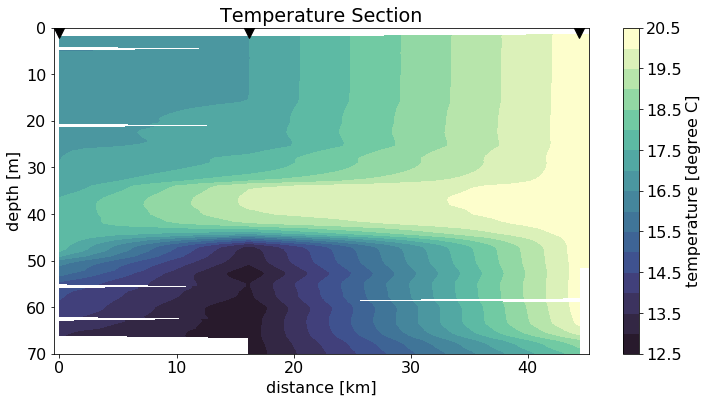

In [34]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
    ax.set_xlim(-.5,45.25)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.temperature.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Temperature Section")

# plt.savefig('Figures/temperaturesection789.png')

Text(0.5, 1.0, 'Salinity Section')

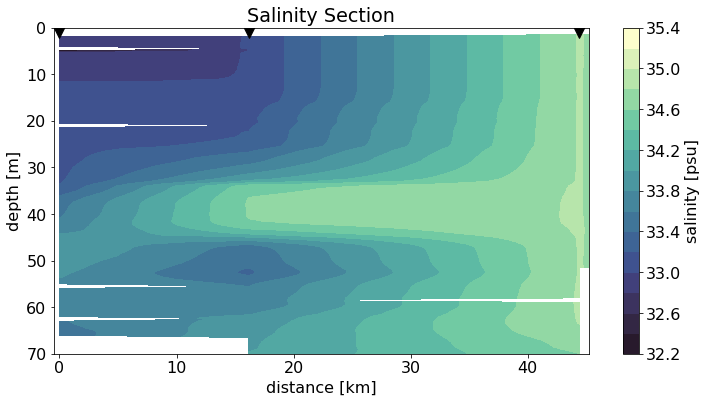

In [24]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
    ax.set_xlim(-.5,45.25)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.salinity.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Salinity Section")

#plt.savefig('Figures/salinitysection789.png')

Text(0.5, 1.0, 'Fluorescence Section')

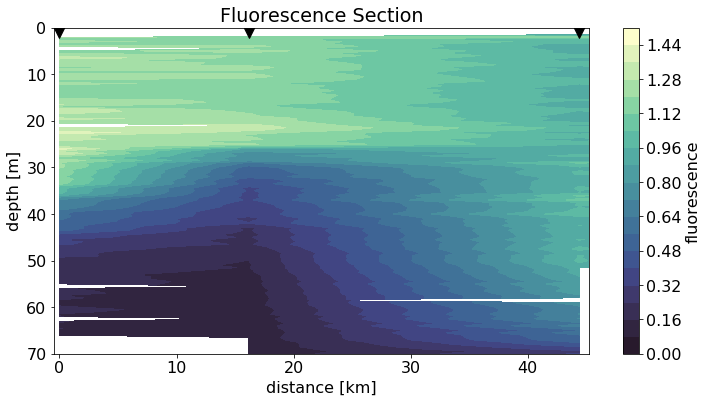

In [25]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
    ax.set_xlim(-.5,45.25)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.fluorescence.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Fluorescence Section")

# plt.savefig('Figures/fluorescencesectionrace6789.png')

# Cruise 1 sections

In [37]:
# read each seabird cast from your directory
data_dir = 'CNV_Cruise_1'

cast4 = fCNV(data_dir+'/Station 4_TSwift_loop_filter_teos10_bin.cnv')
cast5 = fCNV(data_dir+'/Station 5_loop_filter_teos10_bin.cnv')
castWF = fCNV(data_dir+'/Station WF_loop_filter_teos10_bin.cnv')
castRace = fCNV(data_dir+'/TheRace_loop_filter_teos10_bin.cnv')


In [ ]:
# convert the data one station at a time to xarray
# ideally would make this more generic - but for now, it works!

In [ ]:
# get data from cnv file
depth    = cast['DEPTH']
temperature = cast6['TEMP']
salinity    = cast6['PSAL']
fluorescence = cast6['wetStar']

# put the data in a dictionary
datadic = {'depth' : depth, 'temperature' : temperature,
            'salinity' : salinity, 'fluorescence' : fluorescence}

# convert the dictionary to a pandas dataframe
cast6df=pd.DataFrame.from_dict(datadic)

# convert pandas to xarray
cast6xr = cast6df.set_index('depth').to_xarray()

# add latitude and longitude coordinates
cast6xr = cast6xr.assign_coords({'latitude': xr.DataArray(cast6.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(cast6.attributes['LONGITUDE']),
                                 'station':6
                                  }
                                  )   
# cast6xr